# Gaussian Process Model

#### Training Data
Consider a set of training data consisting of input-output pairs $(X_{\text{train}}, Y_{\text{train}})$, where 
- $X_{\text{train}} = \{x_1, x_2, \ldots, x_n\}$ is a set of $n$ input points.
- $Y_{\text{train}} = \{y_1, y_2, \ldots, y_n\}$ is the corresponding set of $n$ output values.

#### Radial Basis Function (RBF) Kernel
The RBF kernel (also known as the squared exponential kernel) between two points $x$ and $x'$ is defined as:
$$ k(x, x') = \sigma^2 \exp\left(-\frac{||x - x'||^2}{2l^2}\right) $$
where 
- $\sigma^2$ is the variance parameter, controlling the vertical variation.
- $l$ is the length scale parameter, controlling the horizontal variation (the smoothness).

#### Covariance Matrix
The covariance matrix $K$ for the training data $X_{\text{train}}$ is formed by applying the RBF kernel to all pairs of training inputs:
$$ K = \begin{bmatrix}
k(x_1, x_1) & k(x_1, x_2) & \cdots & k(x_1, x_n) \\
k(x_2, x_1) & k(x_2, x_2) & \cdots & k(x_2, x_n) \\
\vdots & \vdots & \ddots & \vdots \\
k(x_n, x_1) & k(x_n, x_2) & \cdots & k(x_n, x_n)
\end{bmatrix} $$

#### Posterior Mean and Variance
Given a set of test inputs $X_{\text{test}} = \{x^*_1, x^*_2, \ldots, x^*_m\}$, the Gaussian Process model predicts the posterior mean and variance for each test input. The posterior mean $\mu^*$ and covariance $K^*$ at the test points are given by:
$$ \mu^* = K^*(X_{\text{train}}, X_{\text{test}}) \cdot K^{-1}(X_{\text{train}}, X_{\text{train}}) \cdot Y_{\text{train}} $$
$$ K^* = K(X_{\text{test}}, X_{\text{test}}) - K^*(X_{\text{train}}, X_{\text{test}}) \cdot K^{-1}(X_{\text{train}}, X_{\text{train}}) \cdot K^*(X_{\text{test}}, X_{\text{train}}) $$
where 
- $K^*(X_{\text{train}}, X_{\text{test}})$ is the covariance matrix between the training inputs and test inputs.
- $K(X_{\text{test}}, X_{\text{test}})$ is the covariance matrix between the test inputs.

#### Noise Model
In practice, a noise term $\sigma_n^2 I$ is often added to the diagonal of $K$ to account for observation noise, where $I$ is the identity matrix and $\sigma_n^2$ is the variance of the noise.

#### Negative Log Marginal Likelihood
The Negative Log Marginal Likelihood (NLML) is used for training the hyperparameters of the Gaussian Process. It is given by:
$$ \text{NLML} = \frac{1}{2} Y_{\text{train}}^T K^{-1} Y_{\text{train}} + \frac{1}{2} \log |K| + \frac{n}{2} \log(2\pi) $$


Epoch 1/2000, Loss: 829.6544189453125, NLML: 829.6544189453125, MSE: 0.1695380061864853
Epoch 101/2000, Loss: 710.1248779296875, NLML: 710.1248779296875, MSE: 0.21195609867572784
Epoch 201/2000, Loss: 604.5616455078125, NLML: 604.5616455078125, MSE: 0.2665788233280182
Epoch 301/2000, Loss: 507.3937072753906, NLML: 507.3937072753906, MSE: 0.34719592332839966
Epoch 401/2000, Loss: 432.827392578125, NLML: 432.827392578125, MSE: 0.4189373254776001
Epoch 501/2000, Loss: 380.1894836425781, NLML: 380.1894836425781, MSE: 0.4601794481277466
Epoch 601/2000, Loss: 342.7131042480469, NLML: 342.7131042480469, MSE: 0.48288971185684204
Epoch 701/2000, Loss: 315.3153991699219, NLML: 315.3153991699219, MSE: 0.4940396845340729
Epoch 801/2000, Loss: 295.08905029296875, NLML: 295.08905029296875, MSE: 0.4969080984592438
Epoch 901/2000, Loss: 280.40972900390625, NLML: 280.40972900390625, MSE: 0.4936099946498871
Epoch 1001/2000, Loss: 270.0343017578125, NLML: 270.0343017578125, MSE: 0.4863158166408539
Epoch 

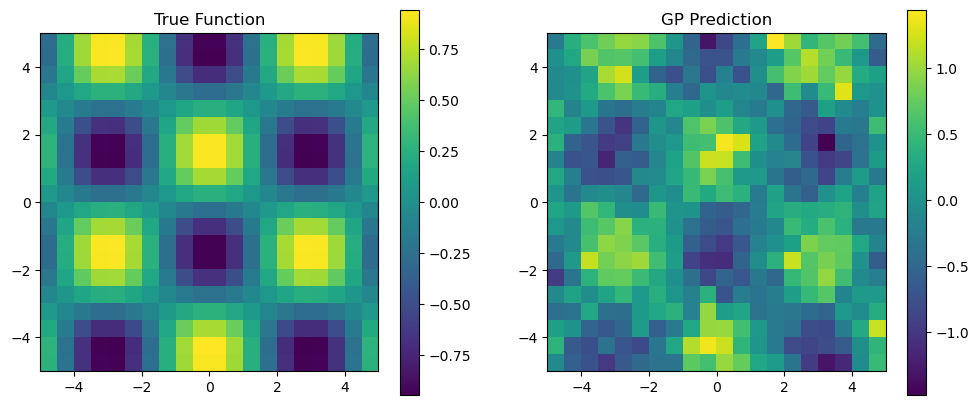

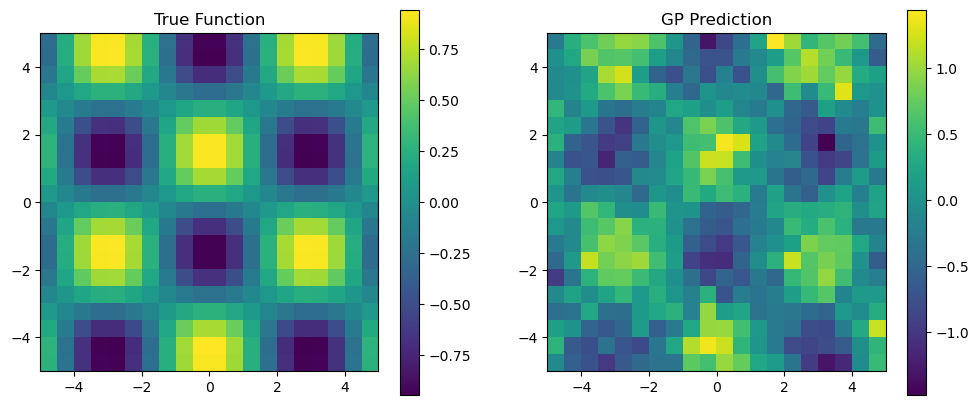

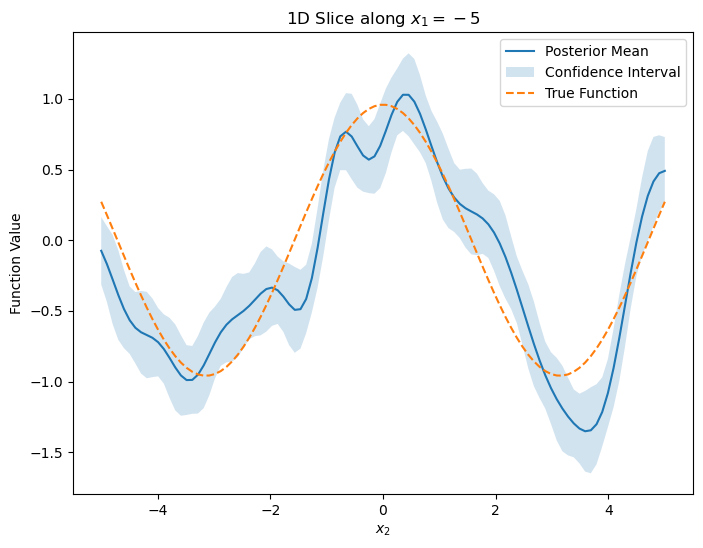

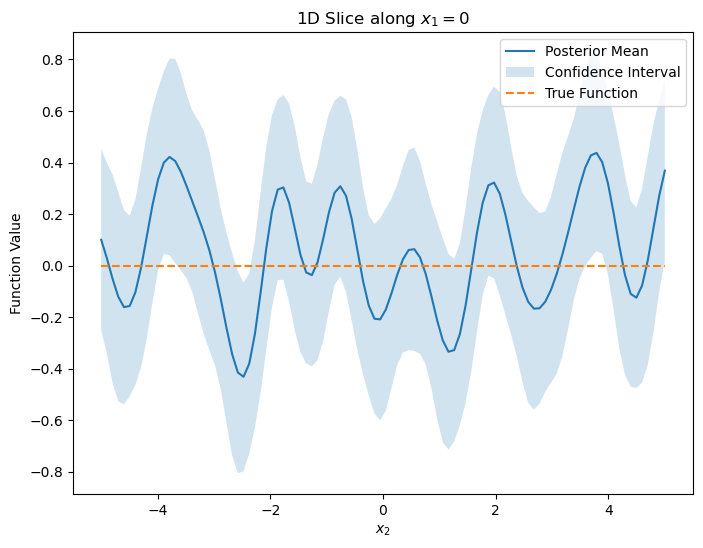

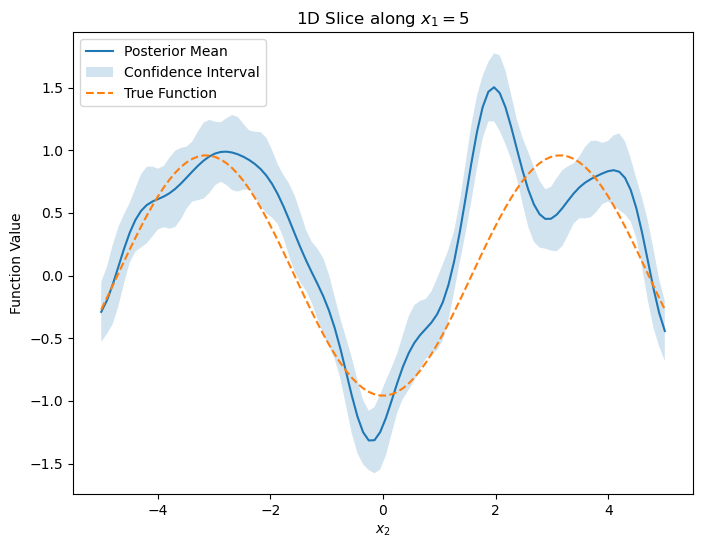

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.optim import Adam


class GaussianProcess(nn.Module):
    def __init__(self, input_dim, var=1.0, length_scale=None, noise_var=0.01):
        super(GaussianProcess, self).__init__()
        self.log_var = nn.Parameter(torch.log(torch.tensor([var], dtype=torch.float32)))
        
        # If length_scale is not provided, initialize it as a tensor of ones
        if length_scale is None:
            length_scale = torch.ones(input_dim, dtype=torch.float32)
        self.log_length_scale = nn.Parameter(torch.log(length_scale))
        
        self.log_noise_var = nn.Parameter(torch.log(torch.tensor([noise_var], dtype=torch.float32)))
        self.X_train = None
        self.y_train = None

    def rbf_kernel(self, X1, X2):
        # Ensure input shapes match
        assert X1.shape[1] == X2.shape[1], "X1 and X2 must have the same number of features"
        
        # Pairwise squared differences for each dimension
        diff = (X1.unsqueeze(1) - X2.unsqueeze(0)).pow(2)
        
        # Length scales for each dimension
        length_scales = torch.exp(self.log_length_scale)
        
        # Apply length scales to the squared differences
        weighted_sq_diff = diff / length_scales.pow(2)
        
        # Sum over the dimensions and negate
        neg_weighted_sq_diff_sum = -0.5 * weighted_sq_diff.sum(-1)
        
        # Compute the kernel matrix
        variance = torch.exp(self.log_var)
        return variance * torch.exp(neg_weighted_sq_diff_sum)


    def nlml(self, X, y):
        # Validate input shapes
        assert X.ndim == 2 and y.ndim == 2, "X and y must be 2D tensors"
        assert X.size(0) == y.size(0), "Number of samples in X and y must match"
        K = self.rbf_kernel(X, X) + torch.exp(self.log_noise_var) * torch.eye(X.size(0))
        L = torch.linalg.cholesky(K + 1e-6 * torch.eye(K.size(0)))
        inv_y = torch.cholesky_solve(y, L)
        logdet = 2 * torch.sum(torch.log(torch.diag(L)))
        return 0.5 * y.t().mm(inv_y) + 0.5 * logdet + 0.5 * X.size(0) * torch.log(torch.tensor(2 * np.pi))

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        # Use the stored training data to make predictions on the test data
        return self._predict(self.X_train, self.y_train, X_test)

    def _predict(self, X_train, y_train, X_test):
        # Calculate kernel matrices
        K = self.rbf_kernel(X_train, X_train) + torch.exp(self.log_noise_var) * torch.eye(X_train.size(0))
        K_s = self.rbf_kernel(X_train, X_test)
        K_ss = self.rbf_kernel(X_test, X_test) + 1e-8 * torch.eye(X_test.size(0))  # Add jitter for stability
        
        # Cholesky decomposition
        L = torch.linalg.cholesky(K + 1e-6 * torch.eye(K.size(0)))
        
        # Compute the mean at our test points
        Lk = torch.linalg.solve(L, K_s)
        mu = torch.matmul(Lk.t(), torch.linalg.solve(L, y_train)).squeeze(-1)
        
        # Compute the variance at our test points
        variance = torch.diag(K_ss) - torch.sum(Lk ** 2, axis=0)
        return mu, variance

    def compute_gradient(self, X):
        """
        Compute the gradient of the GP's predictive mean with respect to the inputs X.

        Parameters:
        X (torch.Tensor): Input tensor for which gradients are to be computed. Must require grad.

        Returns:
        torch.Tensor: Gradients of the predictive mean w.r.t. the input X.
        """
        # Ensure that X requires gradient
        X.requires_grad_(True)

        # Predict the mean at the input points
        # Keep track of the computation graph for this operation to compute gradients later
        mean, _ = self.predict(X)

        # Compute the gradient of the mean w.r.t. X
        gradients = torch.autograd.grad(outputs=mean, inputs=X, grad_outputs=torch.ones_like(mean), create_graph=True)[0]

        # Returning the gradient with respect to the input X
        return gradients.squeeze()

# The true function
def true_func(X, div=False):
    x1, x2 = X[:, 0], X[:, 1]
    if div:
        # Derivative with respect to both dimensions
        df_dx1 = torch.cos(x2) * torch.cos(x1)
        df_dx2 = -torch.sin(x2) * torch.sin(x1)
        return torch.stack([df_dx1, df_dx2], dim=1)
    else:
        # Original function
        return torch.sin(x1) * torch.cos(x2)

def plot_gp(model, x_test):
    model.eval()  # Set model to evaluation mode
    # predict x_test
    mu, var = model.predict(x_test)

    # Create the side-by-side heatmaps
    plt.figure(figsize=(12, 5))

    # True function heatmap
    plt.subplot(1, 2, 1)
    plt.imshow(true_func(x_test).reshape(20,20).detach().numpy(), extent=(-5, 5, -5, 5), origin='lower')
    plt.colorbar()
    plt.title('True Function')

    # GP prediction heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(mu.reshape(20,20).detach().numpy(), extent=(-5, 5, -5, 5), origin='lower')
    plt.colorbar()
    plt.title('GP Prediction')


    plt.show()

def plot_heatmaps(true_values, predicted_values, size, extent, titles):
    plt.figure(figsize=(12, 5))

    # True function heatmap
    plt.subplot(1, 2, 1)
    plt.imshow(true_values.reshape(size, size).detach().numpy(), extent=extent, origin='lower')
    plt.colorbar()
    plt.title(titles[0])

    # GP prediction heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_values.reshape(size, size).detach().numpy(), extent=extent, origin='lower')
    plt.colorbar()
    plt.title(titles[1])

    plt.show()

# Set the random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Generate 2D training data
N = 20
xmin, xmax = -5, 5
noise_var = 0.1

# Create a grid of points in 2D space
x_train = torch.linspace(xmin, xmax, N)
X1, X2 = torch.meshgrid(x_train, x_train)
x_train = torch.stack([X1.flatten(), X2.flatten()], dim=1)

# Create test data similarly, here just using a 1D linspace for simplicity
x_test = torch.linspace(xmin, xmax, 20)
X1_test, X2_test = torch.meshgrid(x_test, x_test)
x_test = torch.stack([X1_test.flatten(), X2_test.flatten()], dim=1)

# Colocation points for computing the derivative loss
x_colocation = torch.stack([X1.flatten(), X2.flatten()], dim=1)

# Evaluate the true function on training data
y_train = true_func(x_train)  # Evaluate the true function
y_train = y_train.unsqueeze(1)  # Ensure y_train is a 2D tensor with shape [100, 1]
y_train += torch.randn(y_train.shape) * torch.sqrt(torch.tensor(noise_var))  # Add noise

# Instantiate the model
input_dim = 2  # For 2D inputs
gp_model = GaussianProcess(input_dim)


# Fit the model with training data
gp_model.fit(x_train, y_train)

# Training settings
learning_rate = 0.001
alpha = 10000
epochs = 2000
optimizer = Adam(gp_model.parameters(), lr=learning_rate)

# Initialize lists to store loss values
total_loss_values = []
nlml_loss_values = []
mse_loss_values = []

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()  # Zero gradients

    # Compute NLML loss
    nlml_loss = gp_model.nlml(x_train, y_train)

    # Compute gradient and residual loss
    predicted_mean_grad = gp_model.compute_gradient(x_colocation)
    true_grad = true_func(x_colocation, div=True)
    residual = predicted_mean_grad - true_grad

    # MSE loss for the residual
    mse_loss = torch.mean(residual ** 2)

    # Total loss
    loss = nlml_loss #+ alpha*mse_loss
    loss.backward()  # Compute gradients
    optimizer.step()  # Update parameters

    # Store losses for plotting
    total_loss_values.append(loss.item())
    nlml_loss_values.append(nlml_loss.item())
    mse_loss_values.append(mse_loss.item())

    # Print progress
    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, NLML: {nlml_loss.item()}, MSE: {mse_loss.item()}')

plot_gp(gp_model, x_test)

# Usage of the function
plot_heatmaps(true_func(x_test), gp_model.predict(x_test)[0], 20, (-5, 5, -5, 5), ['True Function', 'GP Prediction'])


def plot_1d_slices(gp_model, true_func, x1_values, x2_range, uncertainty=1.96):
    """
    Plot 1D slices of the GP posterior mean, lower and upper confidence bounds, and true function.

    Parameters:
    gp_model (GaussianProcess): Trained Gaussian Process model.
    true_func (function): Function that computes the true values.
    x1_values (list): Values of x1 at which to take the 1D slices.
    x2_range (torch.Tensor): Range of x2 values for plotting.
    uncertainty (float): The z-score for the desired confidence interval (default is 95% confidence).
    """
    for x1 in x1_values:
        # Generate test points for the slice
        x_test = torch.tensor([[x1, x2] for x2 in x2_range])

        # Get the posterior mean and variance
        mu, var = gp_model.predict(x_test)
        
        # Compute the lower and upper confidence bounds
        lower = mu - uncertainty * torch.sqrt(var)
        upper = mu + uncertainty * torch.sqrt(var)

        # Get the true function values
        true_values = true_func(x_test)

        # Plot
        plt.figure(figsize=(8, 6))
        plt.plot(x2_range, mu.detach().numpy(), label='Posterior Mean')
        plt.fill_between(x2_range, lower.detach().numpy(), upper.detach().numpy(), alpha=0.2, label='Confidence Interval')
        plt.plot(x2_range, true_values, label='True Function', linestyle='--')
        plt.xlabel('$x_2$')
        plt.ylabel('Function Value')
        plt.title(f'1D Slice along $x_1 = {x1}$')
        plt.legend()
        plt.show()

# Example usage
# x1_values is a list of x1 values where you want to take the slices
# x2_range is a range of x2 values for plotting
x1_values = [-5, 0, 5]
x2_range = torch.linspace(-5, 5, 100)
plot_1d_slices(gp_model, true_func, x1_values, x2_range)



### Enforcing Derivative Matching in Gaussian Process

#### Overview
In addition to minimizing the Negative Log Marginal Likelihood (NLML), the training of the Gaussian Process (GP) model can be augmented by enforcing that the derivative of the GP's posterior mean matches the derivative of the true solution. This approach can be particularly beneficial in problems where the derivatives of the function are as important as the function values themselves, such as in differential equations or gradient-based optimization tasks.

#### Derivative Matching
Let $ X_{\text{colocation}} = \{x^c_1, x^c_2, \ldots, x^c_m\} $ be a set of colocation points where the derivatives are evaluated. The objective is to match the derivatives of the GP's posterior mean at these points with the derivatives of the true solution.

If $ f(x) $ represents the true solution, then its derivative at a colocation point $ x^c $ is given by $ f'(x^c) $. Similarly, the derivative of the GP's posterior mean at $ x^c $ is denoted as $ \mu'(x^c) $.

#### Residual Loss
The residual loss is computed as the mean squared error (MSE) between the predicted derivatives and the true derivatives:
$$ \text{MSE Loss} = \frac{1}{m} \sum_{i=1}^{m} \left( \mu'(x^c_i) - f'(x^c_i) \right)^2 $$

#### Total Loss Function
The total loss function is a weighted sum of the NLML and the MSE loss of the derivatives:
$$ \text{Total Loss} = \text{NLML} + \alpha \cdot \text{MSE Loss} $$
where:
- $\alpha$ is a weighting factor that balances the importance of the NLML and the MSE loss.

#### Training Objective
During training, both the NLML and the MSE loss are minimized simultaneously. This leads to a GP model that not only fits the training data well (as measured by NLML) but also aligns its predictive derivatives with those of the true function (as measured by the MSE loss of derivatives).

#### Implementation in Training Loop
In the training loop, the `compute_gradient` method of the GP model is used to compute $ \mu'(X_{\text{colocation}}) $, and the true derivatives $ f'(X_{\text{colocation}}) $ are obtained using a predefined function. The total loss is then computed as the sum of the NLML and the weighted MSE loss of derivatives, which is used for backpropagation and optimization.
